In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision.datasets as ds
import matplotlib.pyplot as plt

## Load the data (CIFAR-10)

new CustomTensorDataset for transforms

In [2]:
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

In [3]:
def load_cifar(datadir='./data_cache'): # will download ~400MB of data into this dir. Change the dir if neccesary. If using paperspace, you can make this /storage
    train_ds = ds.CIFAR10(root=datadir, train=True,
                           download=True, transform=None)
    test_ds = ds.CIFAR10(root=datadir, train=False,
                          download=True, transform=None)

    def to_xy(dataset):
        X = torch.Tensor(np.transpose(dataset.data, (0, 3, 1, 2))).float() / 255.0  # [0, 1]
        Y = torch.Tensor(np.array(dataset.targets)).long()
        return X, Y

    X_tr, Y_tr = to_xy(train_ds)
    X_te, Y_te = to_xy(test_ds)
    return X_tr, Y_tr, X_te, Y_te

def make_loader(dataset, batch_size=128):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size,
            shuffle=True, num_workers=4, pin_memory=True)

X_tr, Y_tr, X_te, Y_te = load_cifar()

Files already downloaded and verified
Files already downloaded and verified


## Training helper functions

In [4]:
def train_epoch(model, train_dl : DataLoader, opt, k = 50):
    ''' Trains model for one epoch on the provided dataloader, with optimizer opt. Logs stats every k batches.'''
    loss_func = nn.CrossEntropyLoss()
    model.train()
    model.cuda()

    netLoss = 0.0
    nCorrect = 0
    nTotal = 0
    for i, (xB, yB) in enumerate(tqdm(train_dl)):
        opt.zero_grad()
        xB, yB = xB.cuda(), yB.cuda()
        outputs = model(xB)
        loss = loss_func(outputs, yB)
        loss.backward()
        opt.step()
        netLoss += loss.item() * len(xB)
        with torch.no_grad():
            _, preds = torch.max(outputs, dim=1)
            nCorrect += (preds == yB).float().sum()
            nTotal += preds.size(0)
        
        if (i+1) % k == 0:
            train_acc = nCorrect/nTotal
            avg_loss = netLoss/nTotal
            # print(f'\t [Batch {i+1} / {len(train_dl)}] Train Loss: {avg_loss:.3f} \t Train Acc: {train_acc:.3f}')
  
    train_acc = nCorrect/nTotal
    avg_loss = netLoss/nTotal
    return avg_loss, train_acc


def evaluate(model, test_dl, loss_func=nn.CrossEntropyLoss().cuda()):
    ''' Returns loss, acc'''
    model.eval()
    model.cuda()
    nCorrect = 0.0
    nTotal = 0
    net_loss = 0.0
    with torch.no_grad():
        for (xb, yb) in test_dl:
            xb, yb = xb.cuda(), yb.cuda()
            outputs = model(xb)
            loss = len(xb) * loss_func(outputs, yb)
            _, preds = torch.max(outputs, dim=1)
            nCorrect += (preds == yb).float().sum()
            net_loss += loss
            nTotal += preds.size(0)

    acc = nCorrect.cpu().item() / float(nTotal)
    loss = net_loss.cpu().item() / float(nTotal)
    return loss, acc

In [5]:
## Define model

In [6]:
## 5-Layer CNN for CIFAR
## This is the Myrtle5 network by David Page (https://myrtle.ai/learn/how-to-train-your-resnet-4-architecture/)

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), x.size(1))

def make_cnn(c=64, num_classes=10):
    ''' Returns a 5-layer CNN with width parameter c. '''
    return nn.Sequential(
        # Layer 0
        nn.Conv2d(3, c, kernel_size=3, stride=1,
                  padding=1, bias=True),
        nn.BatchNorm2d(c),
        nn.ReLU(),

        # Layer 1
        nn.Conv2d(c, c*2, kernel_size=3,
                  stride=1, padding=1, bias=True),
        nn.BatchNorm2d(c*2),
        nn.ReLU(),
        nn.MaxPool2d(2),

        # Layer 2
        nn.Conv2d(c*2, c*4, kernel_size=3,
                  stride=1, padding=1, bias=True),
        nn.BatchNorm2d(c*4),
        nn.ReLU(),
        nn.MaxPool2d(2),

        # Layer 3
        nn.Conv2d(c*4, c*8, kernel_size=3,
                  stride=1, padding=1, bias=True),
        nn.BatchNorm2d(c*8),
        nn.ReLU(),
        nn.MaxPool2d(2),

        # Layer 4
        nn.MaxPool2d(4),
        Flatten(),
        nn.Linear(c*8, num_classes, bias=True)
    )

In [7]:
## Train
def train(model, train_dl, test_dl, epochs):
    opt = torch.optim.SGD(model.parameters(), lr=0.1)
    for i in range(epochs):
        train_loss, train_acc = train_epoch(model, train_dl, opt)
        test_loss, test_acc = evaluate(model, test_dl)

        print(f'Epoch {i}:\t Train Loss: {train_loss:.3f} \t Train Acc: {train_acc:.3f}\t Test Acc: {test_acc:.3f}')
    return train_loss, train_acc, test_loss, test_acc

## Problem 2

In [8]:
def noisify_label(Y,p):
    Y_noise = torch.zeros_like(Y)
    for i,y in enumerate(Y):
        r=np.random.uniform()
        if r <= p:
            Y_noise[i] = np.random.randint(0, 10)
        else:
            Y_noise[i] = y

    return Y_noise

In [9]:
ps = [0., .5, 1.]
cs = [4, 64]
epochs = [50, 20, 50, 40, 50, 100]
# epochs = [1,1,1,1,1,1]

train_accs = []
test_accs = []

skip_training = True

if not skip_training:
    run_nr=0
    for p in ps:
        for c in cs:
            print(f"----- p={p}, c={c} -----""")
            Y_tr_noise = noisify_label(Y_tr,p)
            Y_te_noise = noisify_label(Y_te,p)

            train_dl = make_loader(CustomTensorDataset([X_tr, Y_tr_noise]))
            test_dl = make_loader(CustomTensorDataset([X_te, Y_te_noise]))

            model = make_cnn(c=c)

            train_loss, train_acc, test_loss, test_acc = train(model=model, train_dl=train_dl, test_dl=test_dl, epochs=epochs[run_nr])
            run_nr+=1
            train_accs.append(float(train_acc))
            test_accs.append(float(test_acc))



The training kept crashing for me in jupyter lab, so I wrote a script to run directly from command line. results from that are copied and visualized below. 

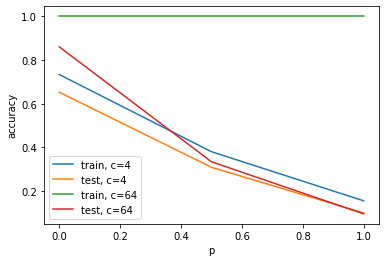

In [10]:
train_accuracies = [0.7333599925041199, 1.0, 0.38023999333381653, 1.0, 0.15553998947143555, 1.0]
train_losses=  [0.7573555888557434, 0.002216150756329298, 1.918847382736206, 0.002550680074095726, 2.2551784664154053, 0.0010338421503081918]
test_accuracies= [0.6523, 0.8598, 0.3089, 0.3342, 0.0999, 0.0956]
test_losses=  [1.05062734375, 0.548130126953125, 2.1132705078125, 3.859871484375, 2.351222265625, 5.58869453125]


plt.figure()
plt.plot(ps, np.array(train_accuracies)[[0,2,4]], label="train, c=4")
plt.plot(ps, np.array(test_accuracies)[[0,2,4]], label="test, c=4")
plt.plot(ps, np.array(train_accuracies)[[1,3,5]], label="train, c=64")
plt.plot(ps, np.array(test_accuracies)[[1,3,5]], label="test, c=64")
plt.xlabel("p")
plt.ylabel("accuracy")
plt.legend()

and with errors...

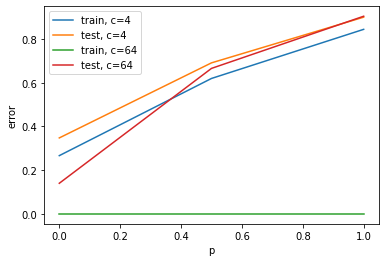

In [11]:
plt.figure()
plt.plot(ps, 1- np.array(train_accuracies)[[0,2,4]], label="train, c=4")
plt.plot(ps, 1- np.array(test_accuracies)[[0,2,4]], label="test, c=4")
plt.plot(ps, 1- np.array(train_accuracies)[[1,3,5]], label="train, c=64")
plt.plot(ps, 1- np.array(test_accuracies)[[1,3,5]], label="test, c=64")
plt.xlabel("p")
plt.ylabel("error")
plt.legend()

observation: p=0,c=4: training acc plateaus at around 73%

#### Discussion
The smaller model cannot fully fit the training data. For c=4, the difference between train and test accuracy is roughly constant as a function of p. 

The larger model (c=64) has enough parameters to fully fit the training dataset for all values of p, achieving ~100% accuracy in all settings. For clean data (p=0), this means that the larger model performs much better on the test data, as it correctly learns more of the underlying 'true' features of the data than the model with c=4. For p=0.5, there may still be some 'true' features in the training data that the larger model can pick up, which the smaller model cannot learn due to lack in capacity - hence a slightly higher test accuracy for c=64. For p=1., there are no 'true' features left that correlate with any of the classes, as all labels are random, and both models achieve the same test accuracy. 